# Polarization in Wave Optics

This tutorial covers polarization representation and manipulation in Janssen.

## Overview

Light is an electromagnetic wave with electric field oscillations. The **polarization state** describes the direction and temporal evolution of this oscillation:

1. **Linear polarization**: Electric field oscillates along a fixed direction
2. **Circular polarization**: Electric field rotates in a circle (right or left handed)
3. **Elliptical polarization**: General case with elliptical trajectory

This tutorial covers two complementary formalisms:

- **Jones calculus**: For fully polarized, coherent light. Uses 2-component complex vectors and 2×2 matrices.
- **Mueller-Stokes calculus**: For partially polarized or unpolarized light. Uses 4-component real vectors and 4×4 matrices.

Both are essential for different applications: Jones for coherent optical systems, Mueller-Stokes for depolarizing elements or incoherent sources.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as mpgs
from matplotlib.patches import Ellipse
import numpy as np
import janssen as jns
from janssen.models import (
    x_polarized_beam, y_polarized_beam, linear_polarized_beam,
    circular_polarized_beam, radially_polarized_beam, azimuthally_polarized_beam
)
from janssen.optics import polarizer_jones, waveplate_jones, quarter_waveplate, half_waveplate

# Configure matplotlib for publication figures
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['TeX Gyre Heros']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'TeX Gyre Heros'
plt.rcParams['mathtext.it'] = 'TeX Gyre Heros:italic'
plt.rcParams['mathtext.bf'] = 'TeX Gyre Heros:bold'

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['figure.titlesize'] = 7

## Setup: Physical Parameters

We define common parameters for our polarized beams.

In [2]:
# Physical parameters
wavelength = 633e-9  # HeNe laser, 633 nm
dx = 100e-9  # 100 nm pixel size
grid_size = (256, 256)
beam_radius = 10e-6  # 10 um beam radius

# Derived quantities
physical_size = grid_size[0] * dx
extent_um = [-physical_size/2*1e6, physical_size/2*1e6,
             -physical_size/2*1e6, physical_size/2*1e6]

print(f"Wavelength: {wavelength*1e9:.0f} nm")
print(f"Grid: {grid_size[0]}x{grid_size[1]}, dx = {dx*1e9:.0f} nm")
print(f"Beam radius: {beam_radius*1e6:.0f} um")
print(f"Physical extent: {physical_size*1e6:.1f} um")

Wavelength: 633 nm
Grid: 256x256, dx = 100 nm
Beam radius: 10 um
Physical extent: 25.6 um


---
# Part I: Jones Calculus

## 1.1 Jones Vectors

A fully polarized monochromatic plane wave can be written as:

$$\vec{E}(z,t) = \begin{pmatrix} E_x \\ E_y \end{pmatrix} e^{i(kz - \omega t)}$$

The **Jones vector** is the complex 2-component vector:

$$\vec{J} = \begin{pmatrix} E_x \\ E_y \end{pmatrix} = \begin{pmatrix} A_x e^{i\phi_x} \\ A_y e^{i\phi_y} \end{pmatrix}$$

Common polarization states:

| State | Jones Vector | Description |
|-------|--------------|-------------|
| Horizontal (H) | $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ | Linear along x |
| Vertical (V) | $\begin{pmatrix} 0 \\ 1 \end{pmatrix}$ | Linear along y |
| Diagonal (+45°) | $\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$ | Linear at 45° |
| Anti-diagonal (-45°) | $\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ -1 \end{pmatrix}$ | Linear at -45° |
| Right circular (RCP) | $\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ -i \end{pmatrix}$ | Clockwise rotation |
| Left circular (LCP) | $\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ i \end{pmatrix}$ | Counter-clockwise |

In [3]:
# Create beams with different polarization states
beam_h = x_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
beam_v = y_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
beam_d = linear_polarized_beam(wavelength, dx, grid_size, 
                                polarization_angle=jnp.pi/4, beam_radius=beam_radius)
beam_rcp = circular_polarized_beam(wavelength, dx, grid_size, 
                                    handedness='right', beam_radius=beam_radius)
beam_lcp = circular_polarized_beam(wavelength, dx, grid_size, 
                                    handedness='left', beam_radius=beam_radius)

# Extract Jones vectors at beam center
center = grid_size[0] // 2

def get_jones_at_center(beam):
    """Extract normalized Jones vector at beam center."""
    j = beam.field[center, center, :]
    return j / jnp.abs(j[0])  # Normalize to Ex = 1

print("Jones vectors at beam center (normalized to Ex=1):")
print(f"H-polarized:   [{beam_h.field[center,center,0]:.3f}, {beam_h.field[center,center,1]:.3f}]")
print(f"V-polarized:   [{beam_v.field[center,center,0]:.3f}, {beam_v.field[center,center,1]:.3f}]")
j_d = get_jones_at_center(beam_d)
print(f"+45° linear:   [{j_d[0]:.3f}, {j_d[1]:.3f}]")
j_rcp = get_jones_at_center(beam_rcp)
print(f"RCP:           [{j_rcp[0]:.3f}, {j_rcp[1]:.3f}]")
j_lcp = get_jones_at_center(beam_lcp)
print(f"LCP:           [{j_lcp[0]:.3f}, {j_lcp[1]:.3f}]")

Jones vectors at beam center (normalized to Ex=1):
H-polarized:   [1.000+0.000j, 0.000+0.000j]
V-polarized:   [0.000+0.000j, 1.000+0.000j]
+45° linear:   [1.000+0.000j, 1.000+0.000j]
RCP:           [1.000+0.000j, 0.000-1.000j]
LCP:           [1.000+0.000j, 0.000+1.000j]


## 1.2 Visualizing Polarization States

We visualize the electric field components and polarization ellipses for each state.

In [4]:
def compute_polarization_ellipse(Ex, Ey):
    """Compute polarization ellipse parameters from Jones vector components.
    
    Parameters
    ----------
    Ex, Ey : complex
        Jones vector components
        
    Returns
    -------
    dict with keys:
        'a': semi-major axis
        'b': semi-minor axis  
        'theta': orientation angle (radians)
        'handedness': 'right', 'left', or 'linear'
        'ellipticity': b/a (0 for linear, 1 for circular)
    """
    # Amplitudes and phases
    ax, ay = jnp.abs(Ex), jnp.abs(Ey)
    phi_x, phi_y = jnp.angle(Ex), jnp.angle(Ey)
    delta = phi_y - phi_x  # Phase difference
    
    # Polarization ellipse parameters (Born & Wolf)
    # tan(2*psi) = tan(2*alpha) * cos(delta)
    # sin(2*chi) = sin(2*alpha) * sin(delta)
    # where alpha = arctan(ay/ax), psi = orientation, chi = ellipticity angle
    
    alpha = jnp.arctan2(ay, ax)
    
    # Orientation angle psi
    cos_delta = jnp.cos(delta)
    tan_2alpha = jnp.tan(2 * alpha)
    psi = 0.5 * jnp.arctan2(tan_2alpha * cos_delta, 1.0)
    
    # Ellipticity angle chi
    sin_delta = jnp.sin(delta)
    sin_2alpha = jnp.sin(2 * alpha)
    sin_2chi = sin_2alpha * sin_delta
    sin_2chi = jnp.clip(sin_2chi, -1, 1)
    chi = 0.5 * jnp.arcsin(sin_2chi)
    
    # Semi-axes from total intensity
    I_total = ax**2 + ay**2
    a = jnp.sqrt(I_total) * jnp.abs(jnp.cos(chi))
    b = jnp.sqrt(I_total) * jnp.abs(jnp.sin(chi))
    
    # Ensure a >= b
    a, b = jnp.maximum(a, b), jnp.minimum(a, b)
    
    # Handedness: sin(delta) > 0 -> left, < 0 -> right
    if jnp.abs(sin_delta) < 0.01:
        handedness = 'linear'
    elif sin_delta > 0:
        handedness = 'left'
    else:
        handedness = 'right'
    
    ellipticity = float(b / (a + 1e-10))
    
    return {
        'a': float(a),
        'b': float(b),
        'theta': float(psi),
        'handedness': handedness,
        'ellipticity': ellipticity
    }

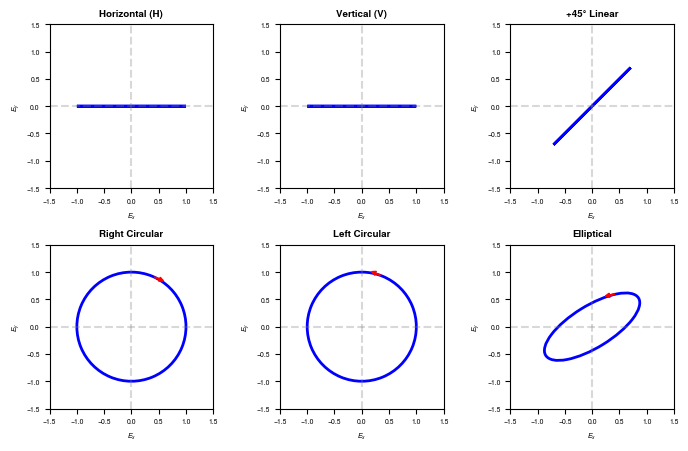

In [5]:
def plot_polarization_state(ax, Ex, Ey, title):
    """Plot polarization ellipse for a Jones vector."""
    params = compute_polarization_ellipse(Ex, Ey)
    
    # Normalize for visualization
    scale = 1.0 / max(params['a'], 0.01)
    a_norm = params['a'] * scale
    b_norm = params['b'] * scale
    
    # Draw ellipse
    ellipse = Ellipse((0, 0), 2*a_norm, 2*b_norm, 
                       angle=np.degrees(params['theta']),
                       fill=False, color='blue', linewidth=2)
    ax.add_patch(ellipse)
    
    # Draw arrow showing rotation direction for circular/elliptical
    if params['handedness'] != 'linear':
        # Draw small arrow on ellipse
        t = np.pi/4  # Position on ellipse
        x_arrow = a_norm * np.cos(t) * np.cos(params['theta']) - b_norm * np.sin(t) * np.sin(params['theta'])
        y_arrow = a_norm * np.cos(t) * np.sin(params['theta']) + b_norm * np.sin(t) * np.cos(params['theta'])
        
        # Tangent direction
        dx = -a_norm * np.sin(t) * np.cos(params['theta']) - b_norm * np.cos(t) * np.sin(params['theta'])
        dy = -a_norm * np.sin(t) * np.sin(params['theta']) + b_norm * np.cos(t) * np.cos(params['theta'])
        
        if params['handedness'] == 'right':
            dx, dy = -dx, -dy
            
        # Normalize and scale arrow
        norm = np.sqrt(dx**2 + dy**2)
        dx, dy = 0.3 * dx/norm, 0.3 * dy/norm
        
        ax.annotate('', xy=(x_arrow+dx, y_arrow+dy), xytext=(x_arrow, y_arrow),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.set_xlabel('$E_x$')
    ax.set_ylabel('$E_y$')
    ax.set_title(title)

# Plot all polarization states
fig, axes = plt.subplots(2, 3, figsize=(7, 4.5))

states = [
    (1+0j, 0+0j, 'Horizontal (H)'),
    (0+0j, 1+0j, 'Vertical (V)'),
    (1+0j, 1+0j, '+45° Linear'),
    (1+0j, -1j, 'Right Circular'),
    (1+0j, 1j, 'Left Circular'),
    (1+0j, 0.5+0.5j, 'Elliptical')
]

for ax, (Ex, Ey, title) in zip(axes.flat, states):
    # Normalize
    norm = np.sqrt(abs(Ex)**2 + abs(Ey)**2)
    plot_polarization_state(ax, Ex/norm, Ey/norm, title)

plt.tight_layout()
plt.savefig('Figures/polarization_jones_states.pdf', bbox_inches='tight')
plt.savefig('Figures/polarization_jones_states.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.3 Jones Matrices

Optical elements that transform polarization are represented by 2×2 **Jones matrices**:

$$\vec{J}_{out} = \mathbf{M} \cdot \vec{J}_{in}$$

Common Jones matrices:

### Linear Polarizer at angle θ:
$$\mathbf{P}(\theta) = \begin{pmatrix} \cos^2\theta & \cos\theta\sin\theta \\ \cos\theta\sin\theta & \sin^2\theta \end{pmatrix}$$

### Waveplate with retardance δ and fast axis at angle θ:
$$\mathbf{W}(\delta, \theta) = \mathbf{R}(-\theta) \begin{pmatrix} 1 & 0 \\ 0 & e^{i\delta} \end{pmatrix} \mathbf{R}(\theta)$$

Special cases:
- **Quarter-wave plate (QWP)**: $\delta = \pi/2$ — converts linear to circular
- **Half-wave plate (HWP)**: $\delta = \pi$ — rotates linear polarization by $2\theta$

In [6]:
# Demonstrate Jones matrices with Janssen functions

# Start with x-polarized beam
beam_x = x_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
print("Initial: X-polarized beam")
print(f"  Jones at center: [{beam_x.field[center,center,0]:.3f}, {beam_x.field[center,center,1]:.3f}]")

# Pass through horizontal polarizer (should pass unchanged)
beam_after_pol_h = polarizer_jones(beam_x, theta=0.0)
print("\nAfter horizontal polarizer (θ=0):")
print(f"  Jones at center: [{beam_after_pol_h.field[center,center,0]:.3f}, {beam_after_pol_h.field[center,center,1]:.3f}]")

# Pass through vertical polarizer (should block)
beam_after_pol_v = polarizer_jones(beam_x, theta=jnp.pi/2)
print("\nAfter vertical polarizer (θ=π/2):")
print(f"  Jones at center: [{beam_after_pol_v.field[center,center,0]:.3f}, {beam_after_pol_v.field[center,center,1]:.3f}]")
print(f"  (Blocked! Intensity = {jnp.abs(beam_after_pol_v.field[center,center,0])**2 + jnp.abs(beam_after_pol_v.field[center,center,1])**2:.6f})")

# Pass through 45° polarizer
beam_after_pol_45 = polarizer_jones(beam_x, theta=jnp.pi/4)
j45 = beam_after_pol_45.field[center,center,:]
print("\nAfter 45° polarizer (θ=π/4):")
print(f"  Jones at center: [{j45[0]:.3f}, {j45[1]:.3f}]")
print(f"  Ratio Ey/Ex = {j45[1]/j45[0]:.3f} (should be 1.0)")

Initial: X-polarized beam
  Jones at center: [1.000+0.000j, 0.000+0.000j]

After horizontal polarizer (θ=0):
  Jones at center: [1.000+0.000j, 0.000+0.000j]

After vertical polarizer (θ=π/2):
  Jones at center: [0.000+0.000j, 0.000+0.000j]
  (Blocked! Intensity = 0.000000)

After 45° polarizer (θ=π/4):
  Jones at center: [0.500+0.000j, 0.500+0.000j]
  Ratio Ey/Ex = 1.000+0.000j (should be 1.0)


In [7]:
# Demonstrate waveplates

# Start with +45° linear polarization
beam_45 = linear_polarized_beam(wavelength, dx, grid_size, 
                                 polarization_angle=jnp.pi/4, beam_radius=beam_radius)
j_in = beam_45.field[center,center,:]
print("Initial: +45° linear polarization")
print(f"  Jones: [{j_in[0]:.3f}, {j_in[1]:.3f}]")

# Quarter-wave plate with fast axis horizontal -> converts to circular
beam_after_qwp = quarter_waveplate(beam_45, theta=0.0)
j_qwp = beam_after_qwp.field[center,center,:]
print("\nAfter QWP (fast axis horizontal):")
print(f"  Jones: [{j_qwp[0]:.3f}, {j_qwp[1]:.3f}]")
print(f"  Phase difference: {jnp.angle(j_qwp[1]) - jnp.angle(j_qwp[0]):.3f} rad")
print(f"  (Should be π/2 = {jnp.pi/2:.3f} for circular polarization)")

# Start with x-polarized
beam_x = x_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)

# Half-wave plate at 22.5° rotates polarization by 45°
beam_after_hwp = half_waveplate(beam_x, theta=jnp.pi/8)  # 22.5°
j_hwp = beam_after_hwp.field[center,center,:]
print("\nX-polarized after HWP at 22.5°:")
print(f"  Jones: [{j_hwp[0]:.3f}, {j_hwp[1]:.3f}]")
pol_angle = jnp.arctan2(jnp.abs(j_hwp[1]), jnp.abs(j_hwp[0]))
print(f"  Polarization angle: {jnp.degrees(pol_angle):.1f}° (should be 45°)")

Initial: +45° linear polarization
  Jones: [0.707+0.000j, 0.707+0.000j]

After QWP (fast axis horizontal):
  Jones: [0.707+0.000j, 0.000+0.707j]
  Phase difference: 1.571 rad
  (Should be π/2 = 1.571 for circular polarization)

X-polarized after HWP at 22.5°:
  Jones: [0.707+0.000j, 0.707-0.000j]
  Polarization angle: 45.0° (should be 45°)


## 1.4 Cylindrical Vector Beams

Unlike uniformly polarized beams, **cylindrical vector beams** have spatially varying polarization:

- **Radially polarized**: $\vec{E} \propto \hat{r}$ (points outward from axis)
- **Azimuthally polarized**: $\vec{E} \propto \hat{\phi}$ (tangent to circles)

These beams have unique focusing properties crucial for high-NA microscopy.

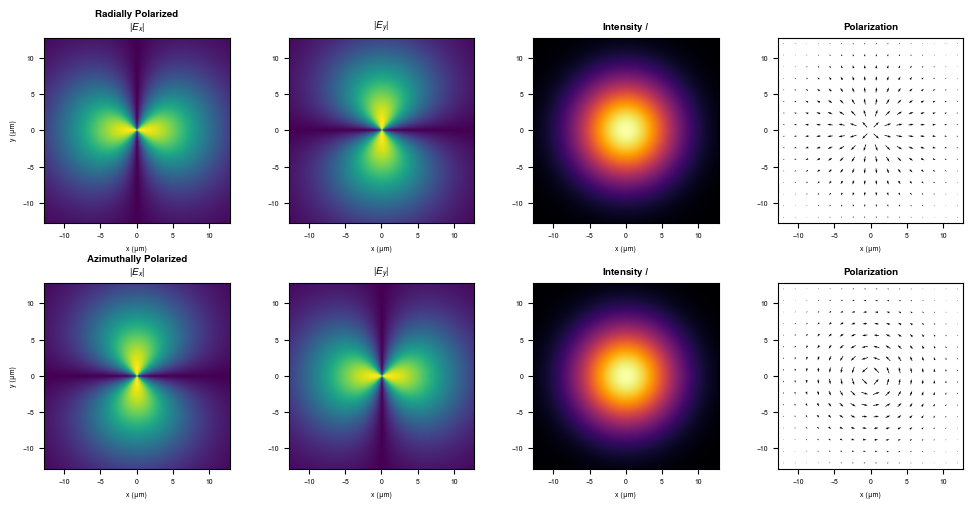

In [8]:
def plot_polarized_beam(wf, title, ax_row):
    """Plot a polarized beam: |Ex|, |Ey|, total intensity, and polarization vectors."""
    ex = wf.field[..., 0]
    ey = wf.field[..., 1]
    
    # |Ex|
    ax_row[0].imshow(jnp.abs(ex), cmap='viridis', extent=extent_um)
    ax_row[0].set_title(f'{title}\n$|E_x|$')
    ax_row[0].set_xlabel('x (μm)')
    ax_row[0].set_ylabel('y (μm)')
    
    # |Ey|
    ax_row[1].imshow(jnp.abs(ey), cmap='viridis', extent=extent_um)
    ax_row[1].set_title('$|E_y|$')
    ax_row[1].set_xlabel('x (μm)')
    
    # Total intensity
    I_total = jnp.abs(ex)**2 + jnp.abs(ey)**2
    ax_row[2].imshow(I_total, cmap='inferno', extent=extent_um)
    ax_row[2].set_title('Intensity $I$')
    ax_row[2].set_xlabel('x (μm)')
    
    # Polarization vectors (quiver plot)
    ny, nx = ex.shape
    step = 16
    y_idx, x_idx = jnp.mgrid[step//2:ny:step, step//2:nx:step]
    
    # Physical coordinates
    x_coords = (x_idx - nx/2) * dx * 1e6
    y_coords = (y_idx - ny/2) * dx * 1e6
    
    u = jnp.real(ex[y_idx, x_idx])
    v = jnp.real(ey[y_idx, x_idx])
    
    ax_row[3].quiver(x_coords, y_coords, u, v, pivot='mid', scale=25)
    ax_row[3].set_xlim(extent_um[0], extent_um[1])
    ax_row[3].set_ylim(extent_um[2], extent_um[3])
    ax_row[3].set_aspect('equal')
    ax_row[3].set_title('Polarization')
    ax_row[3].set_xlabel('x (μm)')

# Create cylindrical vector beams
radial = radially_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
azimuthal = azimuthally_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)

# Plot
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plot_polarized_beam(radial, 'Radially Polarized', axes[0])
plot_polarized_beam(azimuthal, 'Azimuthally Polarized', axes[1])

plt.tight_layout()
plt.savefig('Figures/polarization_cvb.pdf', bbox_inches='tight')
plt.savefig('Figures/polarization_cvb.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.5 Generalized Cylindrical Vector Beams

Higher-order cylindrical vector beams have multiple polarization singularities. The order parameter controls the number of rotations of the polarization direction around the beam axis.

For order $m$:
- $m = 1$: Standard radial/azimuthal beams
- $m = 2$: Four-fold symmetric polarization pattern
- $m = 3$: Six-fold symmetric pattern

The `phase_offset` parameter interpolates between radial-like ($\phi_0 = 0$) and azimuthal-like ($\phi_0 = \pi/2$) patterns.

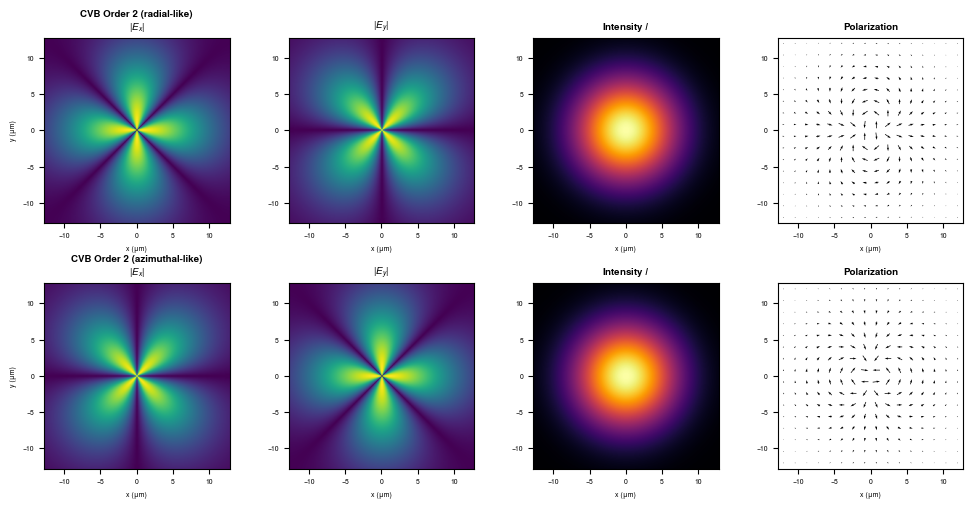

In [9]:
from janssen.models import generalized_cylindrical_vector_beam

# Higher-order CVB (order 2)
cvb_order2_radial = generalized_cylindrical_vector_beam(
    wavelength=wavelength,
    dx=dx,
    grid_size=grid_size,
    order=2,
    phase_offset=0.0,  # Radial-like
    beam_radius=beam_radius,
)

cvb_order2_azim = generalized_cylindrical_vector_beam(
    wavelength=wavelength,
    dx=dx,
    grid_size=grid_size,
    order=2,
    phase_offset=jnp.pi/2,  # Azimuthal-like
    beam_radius=beam_radius,
)

# Plot comparison
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plot_polarized_beam(cvb_order2_radial, 'CVB Order 2 (radial-like)', axes[0])
plot_polarized_beam(cvb_order2_azim, 'CVB Order 2 (azimuthal-like)', axes[1])

plt.tight_layout()
plt.savefig('Figures/polarization_cvb_order2.pdf', bbox_inches='tight')
plt.savefig('Figures/polarization_cvb_order2.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Part II: Mueller-Stokes Calculus

## 2.1 Stokes Parameters

For **partially polarized** or **unpolarized** light, Jones calculus is insufficient. The **Stokes vector** provides a complete description using four real, measurable quantities:

$$\vec{S} = \begin{pmatrix} S_0 \\ S_1 \\ S_2 \\ S_3 \end{pmatrix} = \begin{pmatrix} I \\ I_H - I_V \\ I_{+45} - I_{-45} \\ I_{RCP} - I_{LCP} \end{pmatrix}$$

where:
- $S_0 = I$: Total intensity
- $S_1$: Preference for horizontal vs vertical polarization
- $S_2$: Preference for +45° vs -45° polarization  
- $S_3$: Preference for right vs left circular polarization

The **degree of polarization** (DOP):
$$P = \frac{\sqrt{S_1^2 + S_2^2 + S_3^2}}{S_0}$$

- $P = 1$: Fully polarized
- $P = 0$: Unpolarized
- $0 < P < 1$: Partially polarized

In [10]:
def jones_to_stokes(Ex, Ey):
    """Convert Jones vector to Stokes parameters.
    
    For fully polarized light, computes Stokes vector from Jones vector.
    
    Parameters
    ----------
    Ex, Ey : complex
        Jones vector components
        
    Returns
    -------
    S : array of shape (4,)
        Stokes vector [S0, S1, S2, S3]
    """
    S0 = jnp.abs(Ex)**2 + jnp.abs(Ey)**2
    S1 = jnp.abs(Ex)**2 - jnp.abs(Ey)**2
    S2 = 2 * jnp.real(Ex * jnp.conj(Ey))
    S3 = 2 * jnp.imag(Ex * jnp.conj(Ey))
    
    return jnp.array([S0, S1, S2, S3])

def degree_of_polarization(S):
    """Compute degree of polarization from Stokes vector."""
    return jnp.sqrt(S[1]**2 + S[2]**2 + S[3]**2) / (S[0] + 1e-10)

def stokes_to_jones(S):
    """Convert Stokes vector to Jones vector (for fully polarized light).
    
    Note: Only valid for DOP = 1. Returns one possible Jones vector
    (the global phase is arbitrary).
    """
    S0, S1, S2, S3 = S
    
    # Amplitude
    ax = jnp.sqrt((S0 + S1) / 2)
    ay = jnp.sqrt((S0 - S1) / 2)
    
    # Phase difference
    delta = jnp.arctan2(S3, S2)
    
    Ex = ax
    Ey = ay * jnp.exp(1j * delta)
    
    return Ex, Ey

In [11]:
# Compute Stokes parameters for various polarization states
print("Stokes parameters for common polarization states:")
print("State               S0    S1    S2    S3    DOP")
print("-" * 55)

states = [
    (1+0j, 0+0j, 'Horizontal'),
    (0+0j, 1+0j, 'Vertical'),
    (1/jnp.sqrt(2), 1/jnp.sqrt(2), '+45°'),
    (1/jnp.sqrt(2), -1/jnp.sqrt(2), '-45°'),
    (1/jnp.sqrt(2), -1j/jnp.sqrt(2), 'RCP'),
    (1/jnp.sqrt(2), 1j/jnp.sqrt(2), 'LCP'),
]

for Ex, Ey, name in states:
    S = jones_to_stokes(Ex, Ey)
    dop = degree_of_polarization(S)
    print(f"{name:18s}  {S[0]:5.2f} {S[1]:5.2f} {S[2]:5.2f} {S[3]:5.2f}  {dop:.2f}")

Stokes parameters for common polarization states:
State               S0    S1    S2    S3    DOP
-------------------------------------------------------
Horizontal           1.00  1.00  0.00  0.00  1.00
Vertical             1.00 -1.00  0.00  0.00  1.00
+45°                 1.00  0.00  1.00  0.00  1.00
-45°                 1.00  0.00 -1.00  0.00  1.00
RCP                  1.00  0.00 -0.00  1.00  1.00
LCP                  1.00  0.00  0.00 -1.00  1.00


## 2.2 Mueller Matrices

Optical elements transform Stokes vectors via 4×4 **Mueller matrices**:

$$\vec{S}_{out} = \mathbf{M} \cdot \vec{S}_{in}$$

Mueller matrices can describe:
- Polarizing elements (same as Jones)
- **Depolarizing** elements (cannot be described by Jones!)
- Partially polarizing elements

### Linear Polarizer (horizontal):
$$\mathbf{M}_{H} = \frac{1}{2}\begin{pmatrix} 1 & 1 & 0 & 0 \\ 1 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{pmatrix}$$

### Quarter-wave plate (fast axis horizontal):
$$\mathbf{M}_{QWP} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -1 & 0 \end{pmatrix}$$

### Ideal Depolarizer:
$$\mathbf{M}_{depol} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{pmatrix}$$

In [12]:
def mueller_linear_polarizer(theta):
    """Mueller matrix for linear polarizer at angle theta."""
    c2 = jnp.cos(2*theta)
    s2 = jnp.sin(2*theta)
    
    M = 0.5 * jnp.array([
        [1,    c2,   s2,   0],
        [c2,   c2**2, c2*s2, 0],
        [s2,   c2*s2, s2**2, 0],
        [0,    0,    0,    0]
    ])
    return M

def mueller_waveplate(delta, theta):
    """Mueller matrix for waveplate with retardance delta, fast axis at theta."""
    c2 = jnp.cos(2*theta)
    s2 = jnp.sin(2*theta)
    cd = jnp.cos(delta)
    sd = jnp.sin(delta)
    
    M = jnp.array([
        [1, 0, 0, 0],
        [0, c2**2 + s2**2*cd, c2*s2*(1-cd), -s2*sd],
        [0, c2*s2*(1-cd), s2**2 + c2**2*cd, c2*sd],
        [0, s2*sd, -c2*sd, cd]
    ])
    return M

def mueller_qwp(theta):
    """Mueller matrix for quarter-wave plate."""
    return mueller_waveplate(jnp.pi/2, theta)

def mueller_hwp(theta):
    """Mueller matrix for half-wave plate."""
    return mueller_waveplate(jnp.pi, theta)

def mueller_depolarizer(p=0.0):
    """Mueller matrix for partial depolarizer.
    
    p = 0: complete depolarization
    p = 1: no depolarization (identity)
    """
    return jnp.array([
        [1, 0, 0, 0],
        [0, p, 0, 0],
        [0, 0, p, 0],
        [0, 0, 0, p]
    ])

def apply_mueller(M, S):
    """Apply Mueller matrix to Stokes vector."""
    return M @ S

In [13]:
# Demonstrate Mueller calculus

# Start with unpolarized light
S_unpol = jnp.array([1.0, 0.0, 0.0, 0.0])
print("Unpolarized light:")
print(f"  Stokes: {S_unpol}")
print(f"  DOP: {degree_of_polarization(S_unpol):.2f}")

# Pass through horizontal polarizer
M_H = mueller_linear_polarizer(0.0)
S_after_pol = apply_mueller(M_H, S_unpol)
print("\nAfter horizontal polarizer:")
print(f"  Stokes: {S_after_pol}")
print(f"  DOP: {degree_of_polarization(S_after_pol):.2f}")

# Start with H-polarized, pass through QWP at 45°
S_H = jnp.array([1.0, 1.0, 0.0, 0.0])
M_QWP = mueller_qwp(jnp.pi/4)  # Fast axis at 45°
S_after_qwp = apply_mueller(M_QWP, S_H)
print("\nH-polarized through QWP at 45°:")
print(f"  Input Stokes:  {S_H}")
print(f"  Output Stokes: {S_after_qwp}")
print(f"  (Should be circularly polarized: S3 ≠ 0)")

# Demonstrate depolarization (impossible with Jones!)
S_polarized = jnp.array([1.0, 0.5, 0.5, 0.5])  # Elliptically polarized
print(f"\nElliptically polarized (DOP = {degree_of_polarization(S_polarized):.2f}):")
print(f"  Stokes: {S_polarized}")

# Partial depolarization
for p in [0.8, 0.5, 0.0]:
    M_dep = mueller_depolarizer(p)
    S_out = apply_mueller(M_dep, S_polarized)
    print(f"  After depolarizer (p={p}): DOP = {degree_of_polarization(S_out):.2f}")

Unpolarized light:
  Stokes: [1. 0. 0. 0.]
  DOP: 0.00

After horizontal polarizer:
  Stokes: [0.5 0.5 0.  0. ]
  DOP: 1.00

H-polarized through QWP at 45°:
  Input Stokes:  [1. 1. 0. 0.]
  Output Stokes: [1.000000e+00 6.123234e-17 6.123234e-17 1.000000e+00]
  (Should be circularly polarized: S3 ≠ 0)

Elliptically polarized (DOP = 0.87):
  Stokes: [1.  0.5 0.5 0.5]
  After depolarizer (p=0.8): DOP = 0.69
  After depolarizer (p=0.5): DOP = 0.43
  After depolarizer (p=0.0): DOP = 0.00


## 2.3 The Poincaré Sphere

Fully polarized states can be visualized on the **Poincaré sphere**, where:
- Coordinates $(S_1/S_0, S_2/S_0, S_3/S_0)$ define a point on the unit sphere
- Equator: linear polarization (H, V, ±45°)
- Poles: circular polarization (RCP at north, LCP at south)
- Interior points: partially polarized (DOP < 1)
- Origin: unpolarized

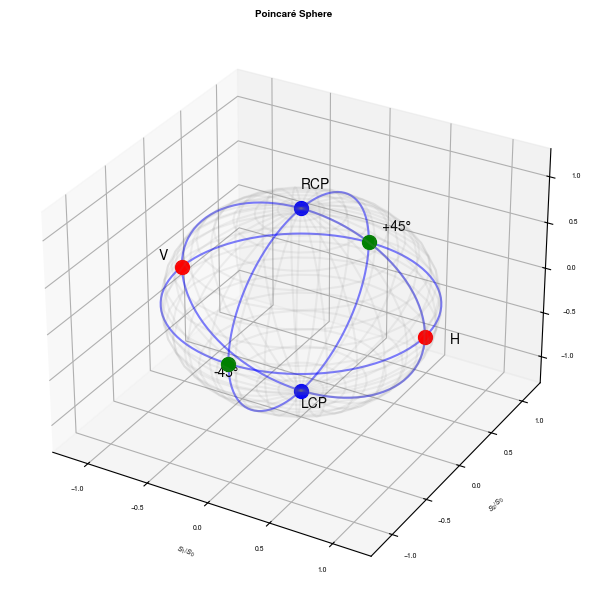

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Draw sphere wireframe
u = np.linspace(0, 2*np.pi, 30)
v = np.linspace(0, np.pi, 20)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')

# Draw equator and meridians
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), np.zeros_like(theta), 'b-', alpha=0.5)
ax.plot(np.zeros_like(theta), np.cos(theta), np.sin(theta), 'b-', alpha=0.5)
ax.plot(np.cos(theta), np.zeros_like(theta), np.sin(theta), 'b-', alpha=0.5)

# Plot key polarization states
states_3d = [
    ([1, 0, 0], 'H', 'red'),
    ([-1, 0, 0], 'V', 'red'),
    ([0, 1, 0], '+45°', 'green'),
    ([0, -1, 0], '-45°', 'green'),
    ([0, 0, 1], 'RCP', 'blue'),
    ([0, 0, -1], 'LCP', 'blue'),
]

for coords, label, color in states_3d:
    ax.scatter(*coords, s=100, c=color, marker='o')
    ax.text(coords[0]*1.2, coords[1]*1.2, coords[2]*1.2, label, fontsize=10)

# Draw path: H -> QWP -> circular
# QWP at 45° rotates around S1 axis by 90°
t_path = np.linspace(0, np.pi/2, 50)
path_x = np.ones_like(t_path)  # Stay at S1 = 1
path_y = np.zeros_like(t_path)
path_z = np.sin(t_path)  # Go from 0 to 1
# Actually for QWP at 0° on +45° input:
path_x = np.cos(t_path)  # S1 stays
path_y = np.sin(t_path) * np.cos(t_path)  # S2 changes
path_z = np.sin(t_path)  # S3 changes

ax.set_xlabel('$S_1/S_0$')
ax.set_ylabel('$S_2/S_0$')
ax.set_zlabel('$S_3/S_0$')
ax.set_title('Poincaré Sphere')

# Equal aspect ratio
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)

plt.tight_layout()
plt.savefig('Figures/polarization_poincare.pdf', bbox_inches='tight')
plt.savefig('Figures/polarization_poincare.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Part III: Differentiable Polarization Optics

## 3.1 Gradient-Based Optimization

Because Janssen implements polarization using JAX, we can compute gradients with respect to polarization parameters. This enables:

1. **Polarimeter inversion**: Recover waveplate angles from measured intensities
2. **Polarization state optimization**: Find optical elements to achieve target polarization
3. **Sensitivity analysis**: How does output depend on element orientation errors?

In [15]:
# Problem: Given H-polarized input and a target output polarization,
# find the QWP and HWP angles to achieve it.

# Target: +45° linear polarization
target_jones = jnp.array([1.0, 1.0]) / jnp.sqrt(2)

def optical_system(qwp_angle, hwp_angle):
    """H-polarized beam through QWP then HWP. Returns output Jones vector."""
    # Start with H-polarized
    beam = x_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
    
    # Apply QWP
    beam = quarter_waveplate(beam, theta=qwp_angle)
    
    # Apply HWP
    beam = half_waveplate(beam, theta=hwp_angle)
    
    # Return Jones vector at center
    return beam.field[center, center, :]

def loss_fn(params):
    """MSE between output and target Jones vectors."""
    qwp_angle, hwp_angle = params
    output = optical_system(qwp_angle, hwp_angle)
    
    # Normalize both for comparison (ignore global phase)
    output_norm = output / jnp.abs(output[0])
    target_norm = target_jones / jnp.abs(target_jones[0])
    
    # Match magnitudes and relative phase
    return jnp.sum(jnp.abs(output_norm - target_norm)**2)

# Test the loss function
test_params = jnp.array([0.0, 0.0])
print(f"Loss at (0, 0): {loss_fn(test_params):.4f}")

# Compute gradient
grad_fn = jax.grad(loss_fn)
grads = grad_fn(test_params)
print(f"Gradient: {grads}")

Loss at (0, 0): 1.0000
Gradient: [ 2. -4.]


In [16]:
import optax

# Optimize to find waveplate angles
optimizer = optax.adam(learning_rate=0.1)

# Initial guess
params = jnp.array([0.1, 0.1])  # Small random angles
opt_state = optimizer.init(params)

n_iterations = 100
loss_history = []
params_history = [params.copy()]

print("Optimizing QWP and HWP angles to achieve +45° polarization...")
print(f"Target Jones: {target_jones}")
print(f"\nInitial params: QWP={jnp.degrees(params[0]):.1f}°, HWP={jnp.degrees(params[1]):.1f}°")

for i in range(n_iterations):
    loss = loss_fn(params)
    loss_history.append(float(loss))
    
    grads = grad_fn(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    params_history.append(params.copy())
    
    if (i+1) % 20 == 0:
        output = optical_system(params[0], params[1])
        print(f"Iter {i+1}: loss={loss:.6f}, QWP={jnp.degrees(params[0]):.1f}°, HWP={jnp.degrees(params[1]):.1f}°")

# Final result
final_output = optical_system(params[0], params[1])
final_output_norm = final_output / jnp.abs(final_output[0])
print(f"\nFinal params: QWP={jnp.degrees(params[0]):.1f}°, HWP={jnp.degrees(params[1]):.1f}°")
print(f"Output Jones: [{final_output_norm[0]:.3f}, {final_output_norm[1]:.3f}]")
print(f"Target Jones: [{target_jones[0]/target_jones[0]:.3f}, {target_jones[1]/target_jones[0]:.3f}]")

Optimizing QWP and HWP angles to achieve +45° polarization...
Target Jones: [0.70710678 0.70710678]

Initial params: QWP=5.7°, HWP=5.7°
Iter 20: loss=0.000471, QWP=1.5°, HWP=22.1°
Iter 40: loss=0.002001, QWP=-1.0°, HWP=23.0°
Iter 60: loss=0.000242, QWP=0.1°, HWP=22.6°
Iter 80: loss=0.000040, QWP=-0.1°, HWP=22.5°
Iter 100: loss=0.000002, QWP=0.0°, HWP=22.5°

Final params: QWP=0.0°, HWP=22.5°
Output Jones: [1.000-0.000j, 1.003+0.000j]
Target Jones: [1.000, 1.000]


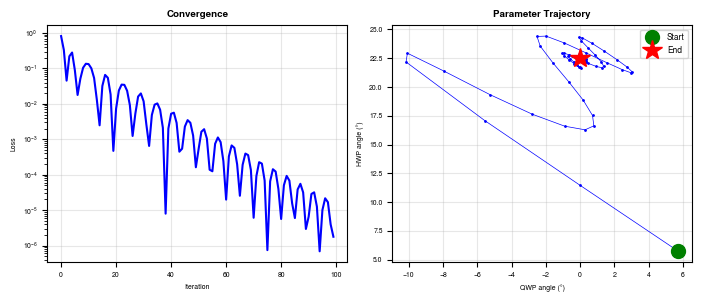

In [17]:
# Plot optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Loss vs iteration
ax = axes[0]
ax.semilogy(loss_history, 'b-', linewidth=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Convergence')
ax.grid(True, alpha=0.3)

# Parameter trajectory
ax = axes[1]
qwp_hist = [jnp.degrees(p[0]) for p in params_history]
hwp_hist = [jnp.degrees(p[1]) for p in params_history]
ax.plot(qwp_hist, hwp_hist, 'b.-', markersize=2, linewidth=0.5)
ax.plot(qwp_hist[0], hwp_hist[0], 'go', markersize=10, label='Start')
ax.plot(qwp_hist[-1], hwp_hist[-1], 'r*', markersize=15, label='End')
ax.set_xlabel('QWP angle (°)')
ax.set_ylabel('HWP angle (°)')
ax.set_title('Parameter Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/polarization_optimization.pdf', bbox_inches='tight')
plt.savefig('Figures/polarization_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.2 Malus's Law Verification

**Malus's Law**: When polarized light passes through a polarizer at angle $\theta$ relative to the polarization direction, the transmitted intensity is:

$$I(\theta) = I_0 \cos^2(\theta)$$

We verify this with Janssen and compute its gradient.

<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:44: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2057486/741445934.py:34: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("Malus's Law: $I = I_0 \cos^2(\\theta)$")
/tmp/ipykernel_2057486/741445934.py:44: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('Gradient: $dI/d\\theta = -I_0 \sin(2\\theta)$')


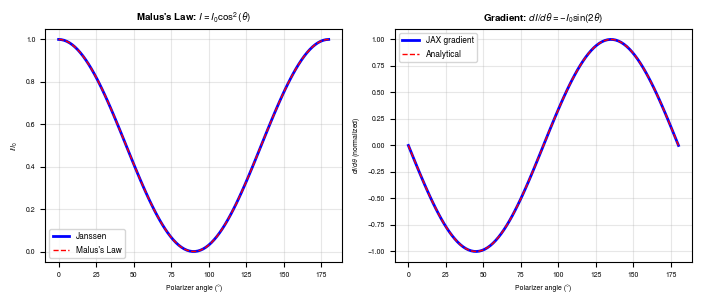

Max error in intensity: 2.22e-16
Max error in gradient: 4.44e-16


In [18]:
# Malus's law verification
angles = jnp.linspace(0, jnp.pi, 100)

def transmitted_intensity(pol_angle):
    """Intensity after x-polarized beam passes through polarizer at pol_angle."""
    beam = x_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
    beam_out = polarizer_jones(beam, theta=pol_angle)
    
    # Intensity at center
    I = jnp.abs(beam_out.field[center, center, 0])**2 + jnp.abs(beam_out.field[center, center, 1])**2
    return I

# Compute intensities
intensities = jnp.array([transmitted_intensity(a) for a in angles])
I0 = transmitted_intensity(0.0)

# Theoretical Malus's law
malus_theory = I0 * jnp.cos(angles)**2

# Compute gradient dI/d(theta)
grad_intensity = jax.grad(transmitted_intensity)
gradients = jnp.array([grad_intensity(a) for a in angles])
grad_theory = -I0 * jnp.sin(2*angles)  # d/dtheta [cos^2(theta)] = -sin(2*theta)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Intensity
ax = axes[0]
ax.plot(jnp.degrees(angles), intensities/I0, 'b-', linewidth=2, label='Janssen')
ax.plot(jnp.degrees(angles), malus_theory/I0, 'r--', linewidth=1, label="Malus's Law")
ax.set_xlabel('Polarizer angle (°)')
ax.set_ylabel('$I/I_0$')
ax.set_title("Malus's Law: $I = I_0 \cos^2(\\theta)$")
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient
ax = axes[1]
ax.plot(jnp.degrees(angles), gradients/I0, 'b-', linewidth=2, label='JAX gradient')
ax.plot(jnp.degrees(angles), grad_theory/I0, 'r--', linewidth=1, label='Analytical')
ax.set_xlabel('Polarizer angle (°)')
ax.set_ylabel('$dI/d\\theta$ (normalized)')
ax.set_title('Gradient: $dI/d\\theta = -I_0 \sin(2\\theta)$')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/polarization_malus.pdf', bbox_inches='tight')
plt.savefig('Figures/polarization_malus.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Max error in intensity: {jnp.max(jnp.abs(intensities - malus_theory)):.2e}")
print(f"Max error in gradient: {jnp.max(jnp.abs(gradients - grad_theory)):.2e}")

---
# Publication Figure

Combined figure showing:
- (a-c) Jones vector polarization ellipses
- (d-e) Cylindrical vector beams
- (f) Poincaré sphere
- (g-h) Malus's law and gradient
- (i) Waveplate optimization

<>:91: SyntaxWarning: invalid escape sequence '\c'
<>:101: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\p'
<>:91: SyntaxWarning: invalid escape sequence '\c'
<>:101: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2057486/2956269917.py:91: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(jnp.degrees(angles), jnp.cos(angles)**2, 'r--', linewidth=1, label='$\cos^2\\theta$')
/tmp/ipykernel_2057486/2956269917.py:101: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(jnp.degrees(angles), -jnp.sin(2*angles), 'r--', linewidth=1, label='$-\sin 2\\theta$')
/tmp/ipykernel_2057486/2956269917.py:103: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\partial I/\partial\\theta$ (norm.)')


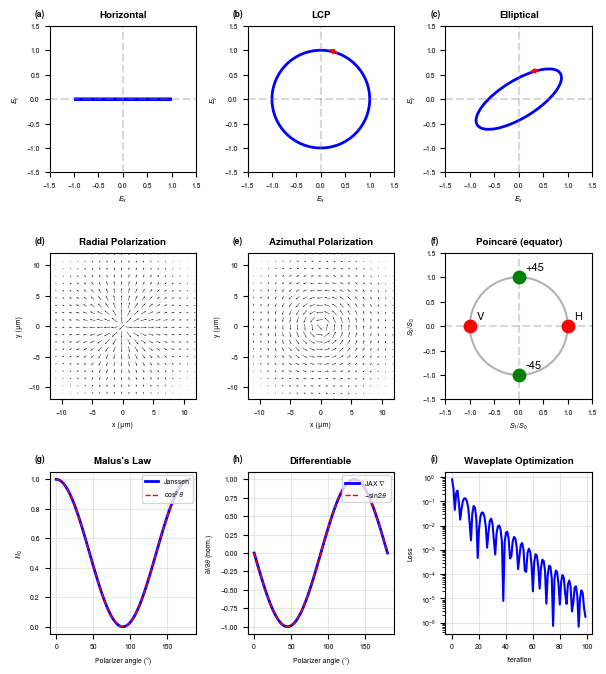

In [19]:
import string

fig = plt.figure(figsize=(7, 8))
gs = mpgs.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.35)

subfig_idx = 0
def get_label():
    global subfig_idx
    label = f'({string.ascii_lowercase[subfig_idx]})'
    subfig_idx += 1
    return label

# Row 1: Polarization states (ellipses)
ellipse_states = [
    (1+0j, 0+0j, 'Horizontal'),
    (1+0j, 1j, 'LCP'),
    (1+0j, 0.5+0.5j, 'Elliptical')
]

for idx, (Ex, Ey, title) in enumerate(ellipse_states):
    ax = fig.add_subplot(gs[0, idx])
    norm = np.sqrt(abs(Ex)**2 + abs(Ey)**2)
    plot_polarization_state(ax, Ex/norm, Ey/norm, title)
    ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

# Row 2: CVB and Poincare
# Radial polarization quiver
ax = fig.add_subplot(gs[1, 0])
radial = radially_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
ex, ey = radial.field[..., 0], radial.field[..., 1]
ny, nx = ex.shape
step = 12
y_idx, x_idx = jnp.mgrid[step//2:ny:step, step//2:nx:step]
x_coords = (x_idx - nx/2) * dx * 1e6
y_coords = (y_idx - ny/2) * dx * 1e6
u = jnp.real(ex[y_idx, x_idx])
v = jnp.real(ey[y_idx, x_idx])
ax.quiver(x_coords, y_coords, u, v, pivot='mid', scale=20)
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_aspect('equal')
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')
ax.set_title('Radial Polarization')
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

# Azimuthal polarization quiver
ax = fig.add_subplot(gs[1, 1])
azimuthal = azimuthally_polarized_beam(wavelength, dx, grid_size, beam_radius=beam_radius)
ex, ey = azimuthal.field[..., 0], azimuthal.field[..., 1]
u = jnp.real(ex[y_idx, x_idx])
v = jnp.real(ey[y_idx, x_idx])
ax.quiver(x_coords, y_coords, u, v, pivot='mid', scale=20)
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_aspect('equal')
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')
ax.set_title('Azimuthal Polarization')
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

# Poincare sphere (2D projection)
ax = fig.add_subplot(gs[1, 2])
theta_circle = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', alpha=0.3)
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

# Plot states (S1 vs S2 projection - equator of Poincare sphere)
poincare_states = [
    (1, 0, 'H', 'red'),
    (-1, 0, 'V', 'red'),
    (0, 1, '+45', 'green'),
    (0, -1, '-45', 'green'),
]
for s1, s2, label, color in poincare_states:
    ax.scatter(s1, s2, s=80, c=color, marker='o', zorder=5)
    ax.annotate(label, (s1, s2), xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('$S_1/S_0$')
ax.set_ylabel('$S_2/S_0$')
ax.set_title('Poincaré (equator)')
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

# Row 3: Malus's law and optimization
ax = fig.add_subplot(gs[2, 0])
ax.plot(jnp.degrees(angles), intensities/I0, 'b-', linewidth=2, label='Janssen')
ax.plot(jnp.degrees(angles), jnp.cos(angles)**2, 'r--', linewidth=1, label='$\cos^2\\theta$')
ax.set_xlabel('Polarizer angle (°)')
ax.set_ylabel('$I/I_0$')
ax.set_title("Malus's Law")
ax.legend(loc='upper right', fontsize=5)
ax.grid(True, alpha=0.3)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

ax = fig.add_subplot(gs[2, 1])
ax.plot(jnp.degrees(angles), gradients/I0, 'b-', linewidth=2, label='JAX $\\nabla$')
ax.plot(jnp.degrees(angles), -jnp.sin(2*angles), 'r--', linewidth=1, label='$-\sin 2\\theta$')
ax.set_xlabel('Polarizer angle (°)')
ax.set_ylabel('$\partial I/\partial\\theta$ (norm.)')
ax.set_title('Differentiable')
ax.legend(loc='upper right', fontsize=5)
ax.grid(True, alpha=0.3)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

ax = fig.add_subplot(gs[2, 2])
ax.semilogy(loss_history, 'b-', linewidth=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Waveplate Optimization')
ax.grid(True, alpha=0.3)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold', va='bottom')

plt.savefig('Figures/polarization_publication_figure.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/polarization_publication_figure.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

---
## Summary

This tutorial demonstrated:

### Jones Calculus (coherent, fully polarized light)
1. **Jones vectors**: 2-component complex vectors representing polarization state
2. **Jones matrices**: 2×2 matrices for polarizers, waveplates
3. **Cylindrical vector beams**: Spatially varying polarization (radial, azimuthal)
4. **Generalized CVB**: Higher-order beams with multiple polarization singularities

### Mueller-Stokes Calculus (partially polarized light)
1. **Stokes vectors**: 4-component real vectors with measurable intensities
2. **Mueller matrices**: 4×4 matrices including depolarizers
3. **Poincaré sphere**: Geometric visualization of polarization states

### Differentiable Polarization Optics
1. **Gradient computation**: JAX enables $\partial I / \partial \theta$ automatically
2. **Parameter optimization**: Recover waveplate angles from target polarization
3. **Malus's law verification**: Exact match with analytical theory

### Key Functions

| Function | Description |
|----------|-------------|
| `x_polarized_beam()`, `y_polarized_beam()` | Linear polarization |
| `circular_polarized_beam()` | RCP/LCP |
| `radially_polarized_beam()` | Radial CVB |
| `azimuthally_polarized_beam()` | Azimuthal CVB |
| `generalized_cylindrical_vector_beam()` | Higher-order CVB |
| `polarizer_jones()` | Linear polarizer (Jones) |
| `quarter_waveplate()`, `half_waveplate()` | Waveplates |
| `jones_to_stokes()` | Convert Jones → Stokes |
| `mueller_linear_polarizer()` | Mueller matrix for polarizer |